# Q-learning

In [24]:
import numpy as np
import random
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
from time import time

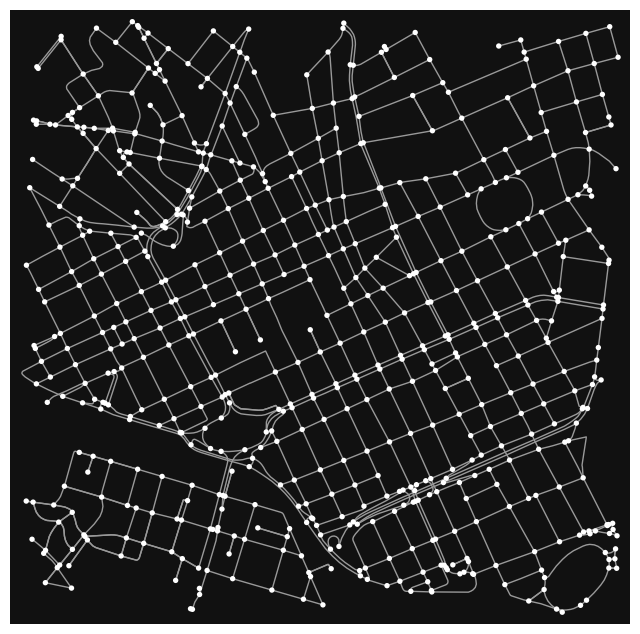

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
G = ox.graph_from_address('Campinas, São Paulo', network_type='drive')
G = nx.convert_node_labels_to_integers(G)
ox.plot_graph(G)

In [3]:
class Environment:
  """
  Simulation of graph route that can be deterministic and stochastic.
  The main functionalities is to reset the simulation and returns the state based in the action.
  """

  def __init__(self, G, source, target, reward="weighted", mode="deterministic"):
    self.G = G
    self.max_weight = max([G[u][v][0]["length"] for u, v, m in G.edges if m == 0])
    self.source = source
    self.target = target
    self.reward = reward
    if mode == "deterministic":
        self.step = self.step_deterministic
    elif mode == "stochastic":
        self.step = self.step_stochastic

  def get_n_states(self):
    """Get number of states"""
    return len(self.G.nodes)

  def reset(self):
    """Return to the source state that is not the destination"""
    self.state = self.source
    # self.state = np.random.choice(list(self.G.nodes))
    # while self.state == self.target:
        # self.state = np.random.choice(list(self.G.nodes))
    return self.state

  def step_deterministic(self, action):
    """Return new state, reward, and if simulation is done"""

    # if is not the target, and the action is to stay in the same node
    if (action == self.state) & (action != self.target):
      return self.state, -1, False
    
    # if reached the target
    if self.state == self.target:
      return self.state, 10000, True
    

    
    # weight of the edge
    w = self.G[self.state][action][0]["length"] / self.max_weight
    # now, the state is the next node
    self.state = action

    # if the action leaves to a dead end
    neighbors = list(self.G.neighbors(self.state))
    if len(neighbors) == 0:
      return self.state, -1000, True

    if self.reward == "unit":
        return self.state, 0, False
    elif self.reward == "weighted":
        return self.state, -w, False

In [23]:
class QLAgent:
    def __init__(
        self, 
        env, 
        learning_rate = 0.7, 
        gamma = 0.99,
        min_epsilon = 0.05,
        max_epsilon = 1,
        n_episodes = 1000,
        max_steps = 1000,
        seed = 42
    ):
        self.env = env
        self.n_states = env.get_n_states()
        self.set_Q()
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        self.n_episodes = n_episodes
        self.max_steps = max_steps
        self.seed = seed
        self.set_seed(seed)

    def set_Q(self):
        self.Q = np.zeros((self.n_states, self.n_states))
        for state in range(self.n_states):
            for action in range(self.n_states):
                if state == action:
                    self.Q[state, action] = 0
                else:
                    try:
                        self.env.G[state][action][0]["length"]
                        self.Q[state, action] = 0
                    except:
                        self.Q[state, action] = -np.inf
                
    def set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
    
    def greedy_policy(self, state):
        """Greedy policy that returns the action with the highest Q value"""
        return np.random.choice(np.where(self.Q[state, :] == np.max(self.Q[state, :]))[0])
    
    def epsilon_greedy_policy(self, state, epsilon):
        """Epsilon greedy policy that returns a random action with probability epsilon"""
        if np.random.uniform(0, 1) < epsilon:
            neighbors = list(self.env.G.neighbors(state)) + [state]
            return np.random.choice(neighbors)
        else:
            return self.greedy_policy(state)

    def generate_episode(self, epsilon):
        state = self.env.reset()
        self.episode_rewards.append(0)
        route = [state]

        for step in range(self.max_steps):
            # Choose action and get reward
            action = self.epsilon_greedy_policy(state, epsilon)
            new_state, reward, done = self.env.step(action)
            self.episode_rewards[-1] += reward    
            
            # update Q table based on Bellman equation
            self.Q[state, action] += self.learning_rate * (
                reward
                + self.gamma * np.max(self.Q[new_state, :])
                - self.Q[state, action]
            )
            state = new_state
            route.append(state)

            if done:
                break
    
    def update_epsilon(self):
        self.epsilon -= (self.max_epsilon - self.min_epsilon) / self.n_episodes
    
    def train(self):
        self.epsilon = self.max_epsilon
        self.episode_rewards = []
        
        for episode in range(self.n_episodes):
            self.generate_episode(self.epsilon)
            self.update_epsilon()

        self.policy = {i : self.greedy_policy(i) for i in range(self.n_states)}
          

    def route_to_target(self, G, source, target):
        route = [source]
        state = source
        cost = 0
        k = 0
        while state != target and k < 1000:
            new_state = self.policy[state]
            cost += G[state][new_state][0]["length"]
            state = new_state
            route.append(state)
            k += 1
        return route, cost 
    

In [59]:
def plot_all_paths_policy(G, policy, source, target):
    """_summary_

    :param G: network
    :type G: networkx.Graph
    :param policy: dict with nodes in keys and the action in values
    :type policy: dict
    :param source: source node
    :type source: int
    :param target: target node
    :type target: int
    """

    plt.scatter(
        [G.nodes[i]["x"] for i in G.nodes],
        [G.nodes[i]["y"] for i in G.nodes],
        alpha = 0.25
    )

    for i in G.nodes:
        dest = policy[i]
        
        # verify if there is a edge between i and dest, if not, continue
        if (i, dest) not in G.edges:
            continue
        
        plt.arrow(
            G.nodes[i]["x"], 
            G.nodes[i]["y"], 
            (G.nodes[dest]["x"] - G.nodes[i]["x"]) * 0.7, 
            (G.nodes[dest]["y"] - G.nodes[i]["y"]) * 0.7, 
            alpha = 0.8, 
            width = 0.0001
        )

    # plot the source and target
    plt.scatter(
        [G.nodes[source]["x"], G.nodes[target]["x"]], 
        [G.nodes[source]["y"], G.nodes[target]["y"]], 
        color = ["green", "red" ],
        alpha = 1,
        s = 100
    )

    # add legend to source and target with the color

    red_patch = mpatches.Patch(color='red', label='Target')
    green_patch = mpatches.Patch(color='green', label='Source')
    plt.legend(handles=[red_patch, green_patch])

    plt.xticks([])
    plt.yticks([])
    plt.show()

def plot_few_steps_policy(G, policy, source, target, steps=5):
    """_summary_

    :param G: network
    :type G: networkx.Graph
    :param policy: dict with nodes in keys and the action in values
    :type policy: dict
    :param source: source node
    :type source: int
    :param target: target node
    :type target: int
    :param steps: number of steps to plot, defaults to 5
    :type steps: int, optional
    """

    plt.scatter(
        [G.nodes[i]["x"] for i in G.nodes],
        [G.nodes[i]["y"] for i in G.nodes],
        alpha = 0.25
    )

    state = source
    for i in range(steps):
        dest = policy[state]
        
        # verify if there is a edge between i and dest, if not, continue
        if (state, dest) not in G.edges:
            raise ValueError(f"There is no edge between {state} and {dest}")
        
        plt.arrow(
            G.nodes[state]["x"], 
            G.nodes[state]["y"], 
            (G.nodes[dest]["x"] - G.nodes[state]["x"]) * 0.95, 
            (G.nodes[dest]["y"] - G.nodes[state]["y"]) * 0.95, 
            alpha = 0.8, 
            width = 0.0001
        )
        state = dest

    # plot the source and target
    plt.scatter(
        [G.nodes[source]["x"], G.nodes[target]["x"]], 
        [G.nodes[source]["y"], G.nodes[target]["y"]], 
        color = ["green", "red" ],
        alpha = 1,
        s = 100
    )

    # add legend to source and target with the color

    red_patch = mpatches.Patch(color='red', label='Target')
    green_patch = mpatches.Patch(color='green', label='Source')
    plt.legend(handles=[red_patch, green_patch])

    plt.xticks([])
    plt.yticks([])
    

In [60]:
seeds = [960703545, 1277478588, 1936856304, 186872697, 1859168769, 1598189534]

### Testing if target is reached

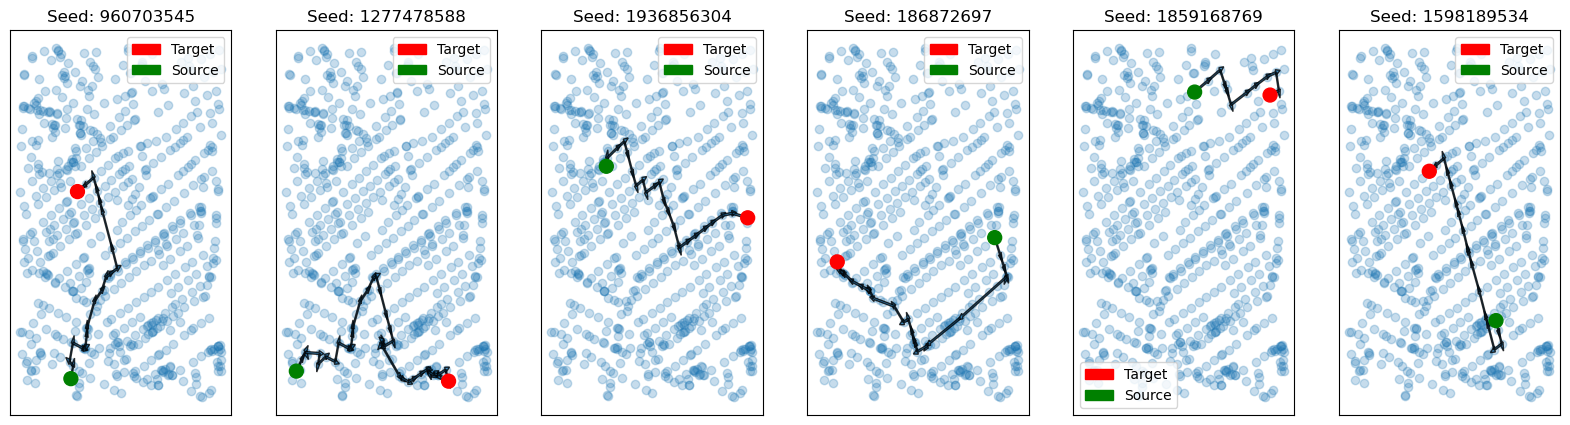

In [61]:
fig, axs = plt.subplots(1, 6, figsize=(20, 5))
for i, seed in enumerate(seeds):
    np.random.seed(seeds[i])
    source = np.random.choice(list(G.nodes))
    target = np.random.choice(G.nodes)
    np.random.seed(seeds[i])
    env = Environment(G, source, target, "unit", "deterministic")
    agent = QLAgent(env)
    agent.train()
    plt.sca(axs[i])
    plot_few_steps_policy(G, agent.policy, source, target, len(agent.route_to_target(G, source, target)[0]) - 1)
    plt.title(f"Seed: {seed}")

### Gamma evaluation

In [56]:
costs = {}
computing_times = {}
for gamma in [0.75, 0.9, 0.95, 0.99]:
    costs[gamma] = []
    computing_times[gamma] = []
    for i in range(len(seeds)):

        np.random.seed(seeds[i])
        source = np.random.choice(list(G.nodes))
        target = np.random.choice(G.nodes)
        np.random.seed(seeds[i])
        env = Environment(G, source, target, "unit", "deterministic")

        start = time()
        agent = QLAgent(env, gamma=gamma)
        agent.train()
        route, cost = agent.route_to_target(G, source, target)
        optim_cost = nx.shortest_path_length(G, source, target, weight="length")
        end = time()
        computing_times[gamma].append(end - start)
        costs[gamma].append(cost/optim_cost)

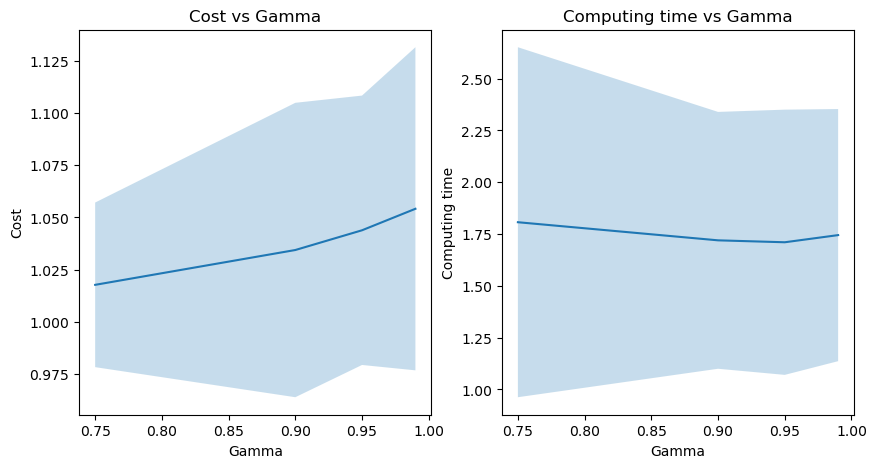

In [57]:
gamma_values = [0.75, 0.9, 0.95, 0.99]
costs_mean = [np.mean(costs[gamma]) for gamma in gamma_values]
computing_times_mean = [np.mean(computing_times[gamma]) for gamma in gamma_values]
costs_std = [np.std(costs[gamma]) for gamma in gamma_values]
computing_times_std = [np.std(computing_times[gamma]) for gamma in gamma_values]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(gamma_values, costs_mean)
axs[0].fill_between(gamma_values, np.array(costs_mean) - np.array(costs_std), np.array(costs_mean) + np.array(costs_std), alpha=0.25)
axs[0].set_xlabel("Gamma")
axs[0].set_ylabel("Cost")
axs[0].set_title("Cost vs Gamma")
axs[1].plot(gamma_values, computing_times_mean)
axs[1].fill_between(gamma_values, np.array(computing_times_mean) - np.array(computing_times_std), np.array(computing_times_mean) + np.array(computing_times_std), alpha=0.25)
axs[1].set_xlabel("Gamma")
axs[1].set_ylabel("Computing time")
axs[1].set_title("Computing time vs Gamma")
plt.show()

### Learning rate evaluation

In [52]:
costs = {}
computing_times = {}
for learning_rate in [0.3, 0.5, 0.7, 0.9]:
    costs[learning_rate] = []
    computing_times[learning_rate] = [] 
    for i in range(len(seeds)):

        np.random.seed(seeds[i])
        source = np.random.choice(list(G.nodes))
        target = np.random.choice(G.nodes)
        np.random.seed(seeds[i])
        env = Environment(G, source, target, "unit", "deterministic")

        start = time()
        agent = QLAgent(env, learning_rate=learning_rate)
        agent.train()
        route, cost = agent.route_to_target(G, source, target)
        optim_cost = nx.shortest_path_length(G, source, target, weight="length")
        end = time()
        computing_times[learning_rate].append(end - start)
        costs[learning_rate].append(cost/optim_cost)

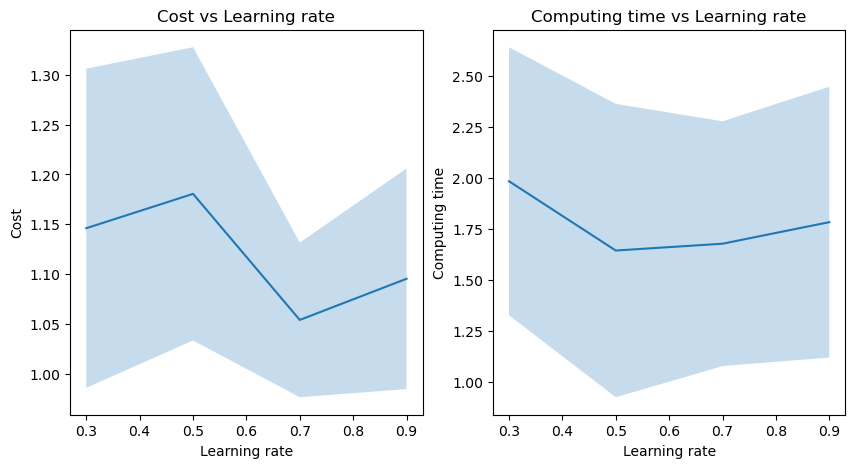

In [55]:
learning_rate_values = [0.3, 0.5, 0.7, 0.9]
costs_mean = [np.mean(costs[learning_rate]) for learning_rate in learning_rate_values]
computing_times_mean = [np.mean(computing_times[learning_rate]) for learning_rate in learning_rate_values]
costs_std = [np.std(costs[learning_rate]) for learning_rate in learning_rate_values]
computing_times_std = [np.std(computing_times[learning_rate]) for learning_rate in learning_rate_values]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(learning_rate_values, costs_mean)
axs[0].fill_between(learning_rate_values, np.array(costs_mean) - np.array(costs_std), np.array(costs_mean) + np.array(costs_std), alpha=0.25)
axs[0].set_xlabel("Learning rate")
axs[0].set_ylabel("Cost")
axs[0].set_title("Cost vs Learning rate")
axs[1].plot(learning_rate_values, computing_times_mean)
axs[1].fill_between(learning_rate_values, np.array(computing_times_mean) - np.array(computing_times_std), np.array(computing_times_mean) + np.array(computing_times_std), alpha=0.25)
axs[1].set_xlabel("Learning rate")
axs[1].set_ylabel("Computing time")
axs[1].set_title("Computing time vs Learning rate")
plt.show()